# IFT6135 Assignment 3
## Neural Turing Machines
### Roger Girgis, Alejandro Podesa, and Matthew Scicluna

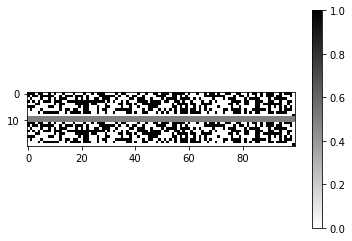

In [4]:
import torch
from torch.autograd import Variable
from model import NTM
from training_dataset import random_binary
import numpy as np
import matplotlib.pyplot as plt


seq_len = 100
model_fname = "checkpoints/copy-batch-80.0.model"
model_type = "NTM"  # "LSTM" or "NTM"


if model_type == "NTM":
    from_before = torch.load(model_fname)
    state_dict = from_before['state_dict']
    controller_type = from_before['controller_type']
    num_inputs = from_before['num_inputs']
    num_outputs = from_before['num_outputs']
    controller_size = from_before['controller_size']
    controller_layers = from_before['controller_layers']
    memory_size = from_before['memory_size']
    batch_size = from_before['batch_size']
    memory_feature_size = from_before['memory_feature_size']
    integer_shift = from_before['integer_shift']
    cuda = from_before['cuda']
    batch_size = 2

    model = NTM(num_inputs=num_inputs, num_outputs=num_outputs, controller_size=controller_size,
                controller_type=controller_type, controller_layers=controller_layers, memory_size=memory_size,
                memory_feature_size=memory_feature_size, integer_shift=integer_shift, batch_size=batch_size, use_cuda=cuda)
    model.load_state_dict(state_dict)

    dataset = random_binary(max_seq_length=seq_len, num_sequences=1, vector_dim=8,
                            batch_Size=batch_size, min_seq_length=seq_len - 1)

    criterion = torch.nn.BCELoss()

    for batch in dataset:
        batch = Variable(torch.FloatTensor(batch))
        if cuda:
            batch = batch.cuda()
        next_r = model.read_head.create_state(batch_size, memory_feature_size)
        if controller_type == 'LSTM':
            lstm_h, lstm_c = model.controller.create_state(1)

        output = Variable(torch.zeros(batch.size()))
        if cuda:
            output = output.cuda()
        for i in range(batch.size()[2]):
            x = batch[:, :, i]
            if controller_type == 'LSTM':
                output[:, :, i], next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r,
                                                                        lstm_h=lstm_h, lstm_c=lstm_c)
            elif controller_type == 'MLP':
                output[:, :, i], next_r = model.forward(x=x, r=next_r)

        break
    
    if cuda:
        X = batch.squeeze(0).data.cpu().numpy()
        Y = output.squeeze(0).data.cpu().numpy()
    else:
        X = batch.squeeze(0).data.numpy()
        Y = output.squeeze(0).data.numpy()

    # Putting the matrices together for nice display, with empty_rows between the two plots
    empty_rows = 2
    data = np.ones((X.shape[1] + Y.shape[1] + empty_rows, X.shape[2])) * 0.5
    data[:X.shape[1], :] = X[0]
    data[X.shape[1] + empty_rows:, :] = Y[0]

    plt.imshow(data, cmap='binary', interpolation='nearest')
    x = plt.colorbar()
    plt.show()


elif model_type == "LSTM":
    pass